In [ ]:
#| export 
import numpy as np
from copy import deepcopy
from fastcore.all import *
from tqdm.auto import tqdm
from functools import partial
from joblib import Parallel, delayed

from bounce.environment import SdPEnvironment
from bounce.agents import DQNAgent, DQN, BrFSAgent, MCAgent
from bounce.utils import (T, array_in_list, state2str, load_checkpoint, save_model, load_model,
                          get_agent_file_name, get_checkpoint_file_name)

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#| default_exp training

In [ ]:
#| include: false
from nbdev.showdoc import show_doc
%load_ext autoreload
%autoreload 2
# %matplotlib inline

# Deep Q-learning trainer

The `DQNTrainer` handles the training of the deep reinforcement learning agent. 

In [ ]:
#| export
class DQNTrainer:
    "Trainer for DQN agents"
    @delegates(DQNAgent.__init__)
    def __init__(self, environment, n_agents=1, models=None, arch=DQN, n_jobs=1, **kwargs):
        self.env = environment
        self.arch = arch
        self.agent_kwargs = kwargs
        self.n_agents = n_agents
        self.parallel = Parallel(n_jobs=n_jobs)
        self.models = models
        self._def_reset()
        self.reset()
        
    def train(self, episodes, id0=0, **kwargs):
        "Performs `n_trains` in parallel."
        train_setups = zip(self.envs, self.agents)
        p_train = partial(train_agent, episodes=episodes, **kwargs)
        results = self.parallel(delayed(p_train)(env, agent, train_id=k+id0) 
                                for k, (env,agent) in enumerate(train_setups))
        return self._process_results(results)     
        
    def change_environment(self, problem=None, sdp_solver=None, budget=None, 
                           reward_criterion="bound_norm", layout_basis=None, bound_tol=1e-3):
        "Changes the environment parameters"
        if problem is None:    problem = self.env.problem
        if budget is None:     budget = self.env.budget
        if sdp_solver is None: sdp_solver = self.env.solver
        self.env = SdPEnvironment(problem, sdp_solver, budget, reward_criterion=reward_criterion,
                                  layout_basis=layout_basis, bound_tol=bound_tol)
        if self.envs is not None: 
            self.envs = [deepcopy(self.env) for _ in range(len(self.envs))]
            
    def set_agent_attrs(self, **attrs):
        "Changes values of the current agents, e.g., `agent.epsilon`"
        for attribute, value in attrs.items():
            [setattr(agent, attribute, value) for agent in self.agents]
        
    def _process_results(self, results):
        "Processes the results as they come out of the parallel"
        agents, envs = [], []
        final_rewards, final_costs, final_bounds, final_optims, expl_optims = [], [], [], [], []
        visited_states, visited_bounds, visited_costs = [], [], []
        oracle_rewards, visited_rewards = [], []
        for result in results:
            agent, env, rewards, cost, bounds, opt_eval, opt_exp = result["training"]
            agents.append(agent); envs.append(env); final_rewards.append(rewards);
            final_costs.append(cost); final_bounds.append(bounds)
            final_optims.append(opt_eval); expl_optims.append(opt_exp)   
            
            states, bounds, cost, o_rewards, env_rewards = result["exploration"]
            visited_states.append(states); visited_bounds.append(bounds); visited_costs.append(cost)
            oracle_rewards.append(o_rewards); visited_rewards.append(env_rewards)
            
        self.agents, self.envs = agents, envs  
        models = [agent.model for agent in agents]
        training_results = {'models': models, 'envs': envs, 'rewards': final_rewards,
                            'costs': final_costs, 'bounds': final_bounds, 
                            'eval_optims': final_optims, 'expl_optims': expl_optims}
        exploration_results = {'agents': models, 'envs': envs, 'visited_states': visited_states,
                               'bounds': visited_bounds, 'costs': visited_costs,
                               'oracle_rewards': oracle_rewards, 'visited_rewards': visited_rewards}
        return {'training': training_results, 'exploration': exploration_results}
    
    def _get_agent(self, model=None):
        "Instantiates the agent given an architecture `arch`."
        if model is None: 
            in_dim = len(self.env.state)
            out_dim = in_dim + 1
            net = self.arch(in_dim, out_dim)
        else: 
            self.arch = model.__class__
            net = deepcopy(model)
        return DQNAgent(net, **self.agent_kwargs)
    
    def _def_reset(self):
        "Defines the reset method."
        if self.models is None: 
            self.reset = self._reset_from_scratch
        else:                
            self.n_agents = len(self.models)
            self.reset = self._reset_from_models
    
    def _reset_from_scratch(self):
        "Restarts the agents and everinoments creating `n_agents` instances"
        self.agents = [self._get_agent() for _ in range(self.n_agents)]
        self.envs = [deepcopy(self.env) for _ in range(self.n_agents)]
        
    def _reset_from_models(self):
        "Restarts the agents and environments from the pre-trained models"
        self.agents = [self._get_agent(model) for model in self.models]
        self.envs = [deepcopy(self.env) for _ in range(len(self.models))]

The `DQNTrainer` depends entirely on the `train_agent` function. This, in itself, relies on several inner functionalities shown below. 

In [ ]:
#| export    
def train_agent(env, agent, episodes, time_steps=20, opt=None, best_ref=None,
                evaluate=True, break_opt=False, train_id=None, ckp=20, save=True):
    "Trains an agent given an environment."
    if train_id is None: train_id = np.random.randint(100, 1000)
    if isinstance(episodes, int): episodes = (episodes,)
    final_reward, final_costs, final_bounds, final_optimals, optimal_states = [], [], [], [], []
    visited_states, visited_bounds, visited_costs, oracle_rewards, visited_rewards = [], [], [], [], []
    ckp_dir = Path("../trained_models/checkpoints/"); ckp_dir.mkdir(parents=True, exist_ok=True)
    ckp_name = None
    breaking = False
                   
    for e in tqdm(range(*episodes)):
        state = deepcopy(env.reset())  # Reset environment at the beginning of each game
        optims = []
        for _ in range(time_steps):           
            next_state, action, bound, cost, err = step(state, agent, env)   # perform step
            agent.memorize(state, action, bound, cost, next_state)           # memorize outcome
            state = deepcopy(next_state)                                               
            
            if opt is not None: optims.append(check_optim(opt, bound, cost)) # Track optims during exploration
            if not array_in_list(state, visited_states): 
                visited_states.append(state)
                visited_bounds.append(bound)
                visited_costs.append(cost)
                visited_rewards.append(get_reward(env, bound, cost))
                if best_ref is not None:
                    oracle_rewards.append(get_reward(env, bound, cost, best_ref=best_ref))
                    
            if break_opt and check_optim(opt, bound, cost): breaking = True; break

        if len(agent.memory) >= agent.batch_size//5:   
            agent.replay(env)                                            # Replay to learn                        
            
        if e%agent.target_update == 0:
            agent.target_net.load_state_dict(agent.model.state_dict())   # Update target network
            
        if evaluate:
            reward, bound, cost = evaluate_agent(agent, env, time_steps) # Evaluate agent
            final_reward.append(reward) 

        final_costs.append(cost)
        final_bounds.append(bound)
        if opt is not None: 
            final_optimals.append(check_optim(opt, bound, cost))
            optimal_states.append(np.mean(optims))
            
        # Save checkpoint    
        if e%ckp == 0 or e==episodes[0]-1 or breaking: 
            if ckp_name is not None: (ckp_dir/ckp_name).unlink()
            ckp_name = f"{get_checkpoint_file_name(env.problem, env.budget, train_id, e)}.pt"
            checkpoint = {'model': agent.model, 'model_state_dict': agent.model.state_dict,
                          'env': env, 'final_reward': final_reward, 'final_costs': final_costs,
                          'final_bounds': final_bounds, 'eval_optims': final_optimals, 
                          'expl_optims': optimal_states, 'visited_states': visited_states,
                          'visited_bounds': visited_bounds, 'visited_costs': visited_costs, 
                          'oracle_rewards': oracle_rewards, 'visited_rewards': visited_rewards}
            torch.save(checkpoint, ckp_dir/ckp_name)
            env.save_memory()
            
        if breaking: break
        
    # Once trained, save updated memory file and trained agent
    env.save_memory()
    if save: save_model(agent, env.problem, env.budget, train_id)
        
    return {'training': (agent, env, final_reward, final_costs, final_bounds, final_optimals, optimal_states),
            'exploration': (visited_states, visited_bounds, visited_costs, oracle_rewards, visited_rewards)}

DQNTrainer.train = delegates(to=train_agent)(DQNTrainer.train)

To train an agent, provide the environment `env` containing the all the details about the problem that is to be solved and the `agent`, which is an initialized `DQNAgent`. The learning process is structured in a number of `episodes` of length `time_steps`. Every episode starts from the same initial state and the agent performs a trajectory through the state space of length `time_steps`. The agent gathers experience throughout the episode that then, once it has gathered enough, it is replayed to learn. The target network for double Q-learning is updated every `agent.target_update` learning episodes.

If `evaluate` is set to `True`, the agent performs an evaluation episode after each training episode. With this, we can keep track of the convergence of the agent by looking at the final state of this episode. For the evaluation, there can be provided the optional `opt` and `best_ref`, which are used to check whether the agent is reaching the optimal configuration and the relative performance with respect to it. When only considering the exploration capabilities, `break_opt` is used to stop the learning process once the agent has encountered the optimal state. 

The optional inputs `train_id`, `ckp` and `save` are meant to handle data storage. With `train_id` we name the agent to save the training data in a consistent way. This is specially important when training agents in parallel, although `DQNTrainer` already handles this automatically. If no `train_id` is provided, the agent is assigned one at random. The training process is backed up every `ckp` training episodes and, if `save` is set to `True`, the resulting trained agent is saved at the end of the training process. 

`train_agent` uses the following functionalities to make the code more readable.

In [ ]:
#| export
def step(state, agent, environment):
    "Take a step forward from state following the agent's policy."
    actions = agent.act(state)
    next_state, action, bound, cost, err = environment.step(actions)
    return next_state, action, bound, cost, err

def get_reward(environment, bound, cost, best_ref=None):
    "Returns the reward according to the environment."
    return environment.reward_fun(T([bound]), T([cost]), best_ref=best_ref).item()

def evaluate_agent(agent, environment, time_steps):
    "Evaluates the agent in deterministic policy. Returns final reward, bound and cost."
    # Policy evaluation
    eps = agent.epsilon
    agent.epsilon = 0                       # Temporarily switch to greedy policy
    state = deepcopy(environment.reset())
    for _ in range(time_steps):
        next_state, _, bound, cost, _ = step(state, agent, environment)    
        state = deepcopy(next_state)    
    # Get the final reward
    reward = environment.reward_fun(T([bound]).to(agent.device), T([cost]).to(agent.device)).item()
    agent.epsilon = eps
    return reward, bound, cost

def check_optim(opt, B, C):
    "Checks whether the current bound `B` and cost `C` match with the optimal ones."
    return np.allclose((B, C), opt)

In [ ]:
#| include: false
from bounce.sdp import SdPEnergySolver
from bounce.hamiltonian import XXHamiltonian, Chain1D
from bounce.utils import plot_trainings, plot_exploration

Let's see how the trainer works. As usual, we start by defining the environment.

In [ ]:
N = 6
chain = Chain1D(N)
b, j = 1, [i%3 for i in range(N)]
H = XXHamiltonian(chain, b, j)
budget = 300
env = SdPEnvironment(H, SdPEnergySolver(), budget)

Then, we define the training parameters. In the training process if we know the optimal set of constraints, we can provide an `opt` reference consisting of a tuple with the optimal bound and cost. Furthermore, with full knowledge of the problem, we can provide the `best_ref` in the form of an `np.array` that contains the optimal bound and cost (like the `opt`), as well as the highest cost with which the optimal bound can be obtained. 

In [ ]:
episodes = 50
time_steps = 7
opt = (-10.94427, 127)
best_ref = np.array([*opt, 288])

With these, we're all set to create our trainer and start training our agent! Even more, we can train a few agents in parallel.

In [ ]:
#| eval: false
dqn = DQNTrainer(env, n_agents=2, n_jobs=2)
results = dqn.train(episodes=episodes, time_steps=time_steps, opt=opt, best_ref=best_ref)

The results are split into training and exploration results. The training results focus on the actual training process of the agents, storing information after every training episode. 

We can quickly visualize those with `plot_trainings` from `bounce.utils`. 

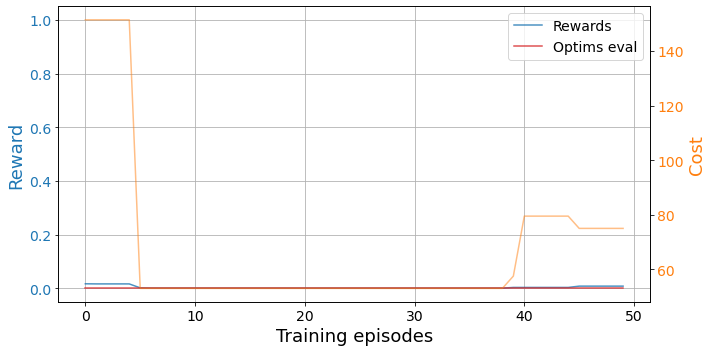

In [ ]:
#| eval: false
plot_trainings(results['training'])

Here we see the reward and cost associated to the state at the end of an evaluation trajectory after every episode. We see that the agent needs some time to converge to a solution.

Conversely, the exploration results track the exploration process through the state space. This way, they store relevant data only after the agent visits a new state. This allows us to see how the agent progresses in its quest to find the optimal relaxation. 

We can visualize those with `plot_exploration` from `bounce.utils`.

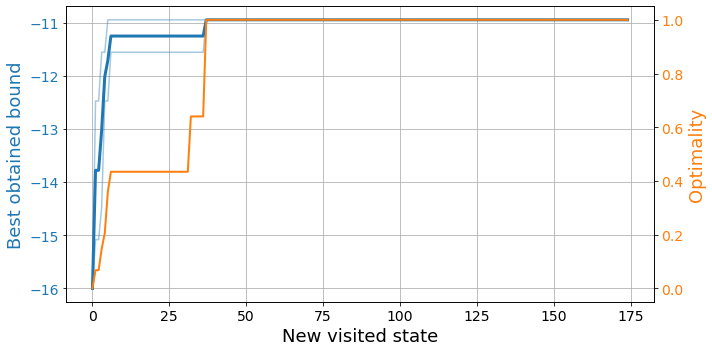

In [ ]:
#| eval: false
plot_exploration(results['exploration'])

Here we see the best bound obtained by the agents at every time step, as well as how close the states are to the global optimum. Remember that finding the optimal relaxation not only involves finding the best possible bound, but doing so with the least amount of parameters.  

# Breadth first search trainer

In [ ]:
#| export
def explore_brfs(env, agent, max_states, opt=None, best_ref=None, break_opt=False):
    "Space exploration with Breadth First Search (BrFS)"
    state_count = 0
    breaking = False
    visited_states, bounds, costs, rewards, optims = [], [], [], [], []
    while state_count < max_states:
        state_root, actions = agent.expand()
        for a in actions: 
            env.state = deepcopy(state_root)
            state_expand, bound, cost, err = env.perform_action(a)
            if not agent.in_closed(state_expand) and not agent.in_open(state_expand):
                if not err: 
                    agent.add_open(state_expand)
                    state_count += 1
                    # Track quantities
                    visited_states.append(state_expand)
                    bounds.append(bound)
                    costs.append(cost)
                    if opt is not None: optims.append(check_optim(opt, bound, cost))
                    if best_ref is not None: 
                        rewards.append(get_reward(env, bound, cost, best_ref=best_ref))
                    if break_opt and check_optim(opt, bound, cost): breaking = True; break
        
                else: 
                    agent.add_closed(state_expand)

        if breaking or len(actions) is 0: break
            
    env.save_memory()
    return agent, env, visited_states, bounds, costs, rewards, optims 

class BrFSTrainer:
    def __init__(self, environment, n_agents=1, n_jobs=1):
        self.env = environment
        self.n_agents = n_agents
        self.parallel = Parallel(n_jobs=n_jobs)
        self.reset()
    
    @delegates(explore_brfs)
    def train(self, max_states, **kwargs):
        "Performs `n_trains` in parallel."
        self.reset() # provisional fix while parallel does not work
        train_setups = zip(self.envs, self.agents)
        p_explore = partial(explore_brfs, max_states=max_states, **kwargs)
        results = self.parallel(delayed(p_explore)(env, agent)
                                for k, (env, agent) in enumerate(train_setups))
        return self._process_results(results) 
        
    def reset(self):
        "Restarts the agents and everinoments creating `n_agents` instances"
        self.agents = [self._get_agent() for _ in range(self.n_agents)]
        self.envs = [deepcopy(self.env) for _ in range(self.n_agents)]
        
    def _process_results(self, results):
        "Processes the results as they come out of the parallel"
        agents, envs, visited_states, bounds, cost, rewards, optims = [], [], [], [], [], [], []
        for res in results:
            agent, env, states, ener, par, rew, opts = res
            agents.append(agent); envs.append(env); visited_states.append(states); 
            bounds.append(ener); cost.append(par); rewards.append(rew); optims.append(opts);   
        
        self.agents, self.envs = agents, envs
        return {'agents': agents, 'envs': envs, 'visited_states': visited_states, 
                'bounds': bounds, 'costs': cost, 'oracle_rewards': rewards, 'optims': optims}
        
    def _get_agent(self):
        "Instantiates an agent."
        return BrFSAgent(self.env.state)       

Neither the breadth first search nor the Monte Carlo algorithms require any actual training. However, we use the "trainers" to explore the state space with them. Therefore, we only receive exploration results. 

In [ ]:
#| eval: false
bfs = BrFSTrainer(env)
results = bfs.train(150, opt=opt, best_ref=best_ref)

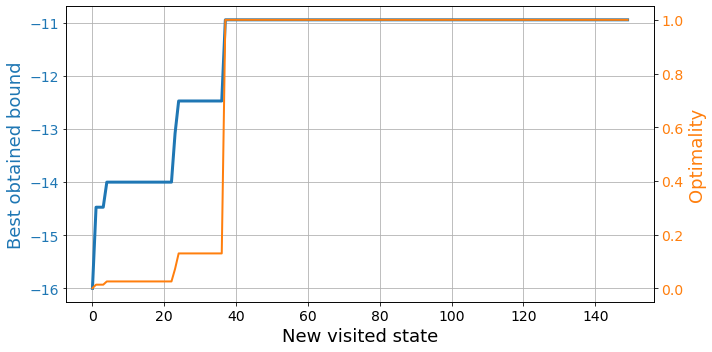

In [ ]:
#| eval: false
plot_exploration(results)

# Monte-Carlo trainer


In [ ]:
#| export
def explore_mc(env, agent, max_states, opt=None, best_ref=None, ckp=20, break_opt=False):
    "Space exploration with Monte-Carlo (MC)"
    visited_states, bounds, costs, oracle_rewards, visited_rewards, optims = [], [], [], [], [], []
    breaking = False
    # Initial state
    state = env.reset()
    bound1, cost1, _ = env.get_values()
    for s in tqdm(range(max_states)):
        state = deepcopy(state)       
        next_state, action, bound2, cost2, err = step(state, agent, env)        
        r1 = get_reward(env, bound1, cost1)
        r2 = get_reward(env, bound2, cost2)
        
        if not array_in_list(next_state, visited_states):
            if err: raise Exception(f"Got an error for state {next_state}")
            visited_states.append(deepcopy(next_state))
            bounds.append(bound2)
            costs.append(cost2)
            visited_rewards.append(r2)
            if opt is not None: optims.append(check_optim(opt, bound2, cost2))
            if best_ref is not None: 
                oracle_rewards.append(get_reward(env, bound2, cost2, best_ref=best_ref))
            if break_opt and check_optim(opt, bound2, cost2): breaking = True; break
        if breaking: break
                
        if agent.accept(r1, r2):
            state = deepcopy(next_state)
            bound1, cost1 = deepcopy(bound2), deepcopy(cost2)
        else: 
            env.state = deepcopy(state)
            
        if s%ckp == 0: env.save_memory()
                          
    env.save_memory()
    return agent, env, visited_states, bounds, costs, oracle_rewards, visited_rewards, optims

class MCTrainer:
    @delegates(MCAgent.__init__)
    def __init__(self, environment, n_agents=1, n_jobs=1, **kwargs):
        self.env = environment
        self.n_agents = n_agents
        self.parallel = Parallel(n_jobs=n_jobs)
        self.agent_kwargs = kwargs
        self.reset()
        
    @delegates(explore_mc)
    def train(self, max_states, **kwargs):
        "Performs `n_trains` in parallel."
        train_setups = zip(self.envs, self.agents)
        p_explore = partial(explore_mc, max_states=max_states, **kwargs)
        results = self.parallel(delayed(p_explore)(env, agent) 
                                for k, (env, agent) in enumerate(train_setups))
        return self._process_results(results) 
        
    def reset(self):
        "Restarts the agents and everinoments creating `n_agents` instances"
        self.agents = [self._get_agent() for _ in range(self.n_agents)]
        self.envs = [deepcopy(self.env) for _ in range(self.n_agents)]
        
    def _process_results(self, results):
        "Processes the results as they come out of the parallel"
        agents, envs, visited_states, visited_bounds, visited_costs = [], [], [], [], []
        oracle_rewards, visited_rewards, optims = [], [], []
        for result in results:
            agent, env, states, bounds, cost, o_rewards, env_rewards, opts = result
            agents.append(agent); envs.append(env); visited_states.append(states); 
            visited_bounds.append(bounds); visited_costs.append(cost)
            oracle_rewards.append(o_rewards); visited_rewards.append(env_rewards); optims.append(opts)
            
        self.agents, self.envs = agents, envs
        return {'agents': agents, 'envs': envs, 'visited_states': visited_states, 
                'bounds': visited_bounds, 'costs': visited_costs, 'oracle_rewards': oracle_rewards, 
                'visited_rewards': visited_rewards, 'expl_optims': optims}

    def _get_agent(self):
        "Instantiates an agent."
        return MCAgent(**self.agent_kwargs)

In [ ]:
#| eval: false
bfs = MCTrainer(env, n_agents=4, n_jobs=2)
results = bfs.train(350, opt=opt, best_ref=best_ref)

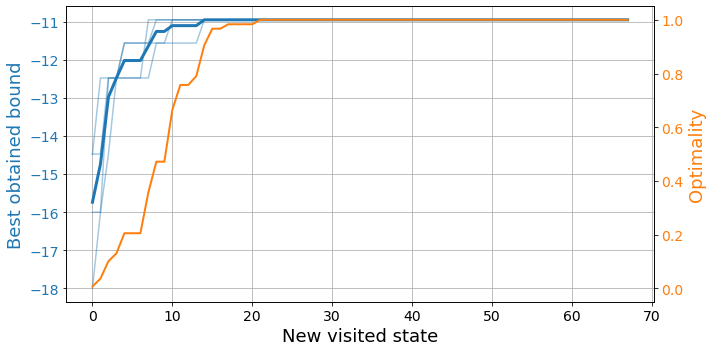

In [ ]:
#| eval: false
plot_exploration(results)

#| hide
# Export-

In [ ]:
#| include: false
from nbdev import nbdev_export
nbdev_export()

Converted 00_environment.ipynb.
Converted 01_agents.ipynb.
Converted 02_budget_profiles.ipynb.
Converted 03_hamiltonian.ipynb.
Converted 04_training.ipynb.
Converted 05_utils.ipynb.
Converted 06_sdp.ipynb.
Converted index.ipynb.
